# Phase 4 Final Project

* Kevin Gross
* Part Time Flatiron School Student

# Real vs. Fake News Data Analysis

## General Overview

Once again, you are expected to communicate the results of an ML modeling process. Just like in Phase 3, we are looking for rationale, results, limitations, and recommendations.

In Phase 4, the emphasis is on the Jupyter Notebook. The notebook should include a summary at the beginning that briefly and accurately describes your process. The summary should be approximately 250 words -- about the size of a research paper abstract.

Summary elements:

Business and data understanding: what kind of data are you using, and what makes it well-suited for the business problem?
You do not need to include any data visualizations in your summary, but consider including relevant descriptive statistics

Data preparation: why did you choose the data preparation steps that you did, and what was the result?
This should be specific to the kind of data you are working with. For example, if you are doing an NLP project, what did you decide to do with stopwords?
Be sure to list the packages/libraries used to prepare the data, and why

Modeling: what modeling package(s) did you use, which model(s) within the package(s), and what tuning steps did you take?
For some projects there may be only one applicable package; you should still briefly explain why this was the appropriate choice
For neural networks projects, be sure to describe your model architecture choices

Evaluation: how well did your final model perform?
Include one or more relevant metrics
Be sure to briefly describe your validation approach

### Import the Necessary Packages and Load the Data

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from matplotlib.ticker import MaxNLocator
from nltk import FreqDist
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk.stem.snowball import SnowballStemmer

In [2]:
# Load the data
real_news = pd.read_csv('Data/True.csv')

# Preview the data
display(real_news.head())
print("True News Shape:", real_news.shape)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

True News Shape: (21417, 4)


In [3]:
real_news['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [4]:
# Load the data
fake_news = pd.read_csv('Data/Fake.csv')

# Preview the data
display(fake_news.head())
print("Fake News Shape:", fake_news.shape)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

Fake News Shape: (23481, 4)


In [5]:
fake_news['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

### Data Understanding

#### Data Source

This dataset was pulled from [Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv) and consists of over 40,000 articles, half of which are real and half of which are fake. 

#### Features

Prior to preprocessing, every row in the dataset contains 4 features:

* `title`: Title of the article
* `text`: Body of the article
* `subject`: The main subject of the article
* `date`: When the article was published

#### Target

As of now, each of the datasets do not include a target column. Let's add that in to each dataset and then combine the two into one large dataframe.

In [6]:
# Add in column consisting of the number 1 for true news
real_news['label'] = 1

# Add in column consisting of the number 0 for fake news
fake_news['label'] = 0

In [59]:
# Merge the two datasets
df = pd.concat([real_news, fake_news])

In [60]:
# Check for missing values
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


## Top Line Data Analysis

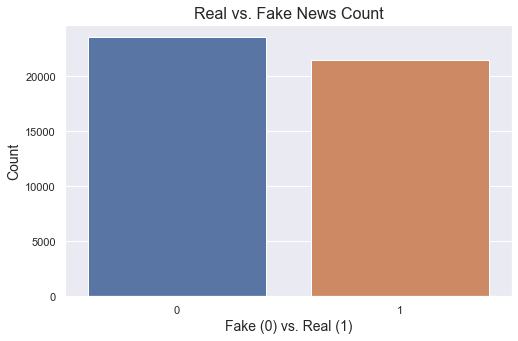

In [62]:
# Create the plot and set the theme
fig, ax = plt.subplots(figsize=(8,5))
sns.set_theme(style='darkgrid')

# Create the graph
sns.countplot(data=df, x=df['label'])

# Set our titles
ax.set_title('Real vs. Fake News Count', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Fake (0) vs. Real (1)', fontsize=14)

# Save our figure for later
plt.savefig('Images/Real vs. Fake News Count.png');

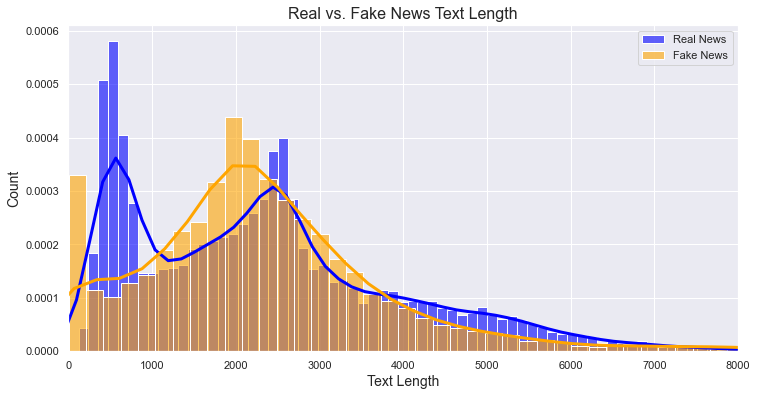

In [11]:
# Get word count of each text
real_len = df[df['label'] == 1]['text'].str.len()
fake_len = df[df['label'] == 0]['text'].str.len()

fig, ax = plt.subplots(figsize=(12,6))
plt.xlim(0, 8000)
sns.histplot(data=df, x=real_len, color='blue', bins=250, alpha=0.6, label='Real News', stat='density')
sns.histplot(data=df, x=fake_len, color='orange', bins=250, alpha=0.6, label='Fake News', stat='density')

sns.kdeplot(real_len, color='blue', linewidth=3)
sns.kdeplot(fake_len, color='orange', linewidth=3)

# Set our titles
ax.set_title('Real vs. Fake News Text Length', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Text Length', fontsize=14)
plt.legend()

# Save our figure for later
plt.savefig('Images/Real vs. Fake News Text Length.png');

### Word Cloud

Let's take a look at our Word Cloud to see what types of words pop up most frequently. 

In [12]:
# Separate our df into real and fake for word cloud
real_df_clean = df[df['label'] == 1]
fake_df_clean = df[df['label'] == 0]

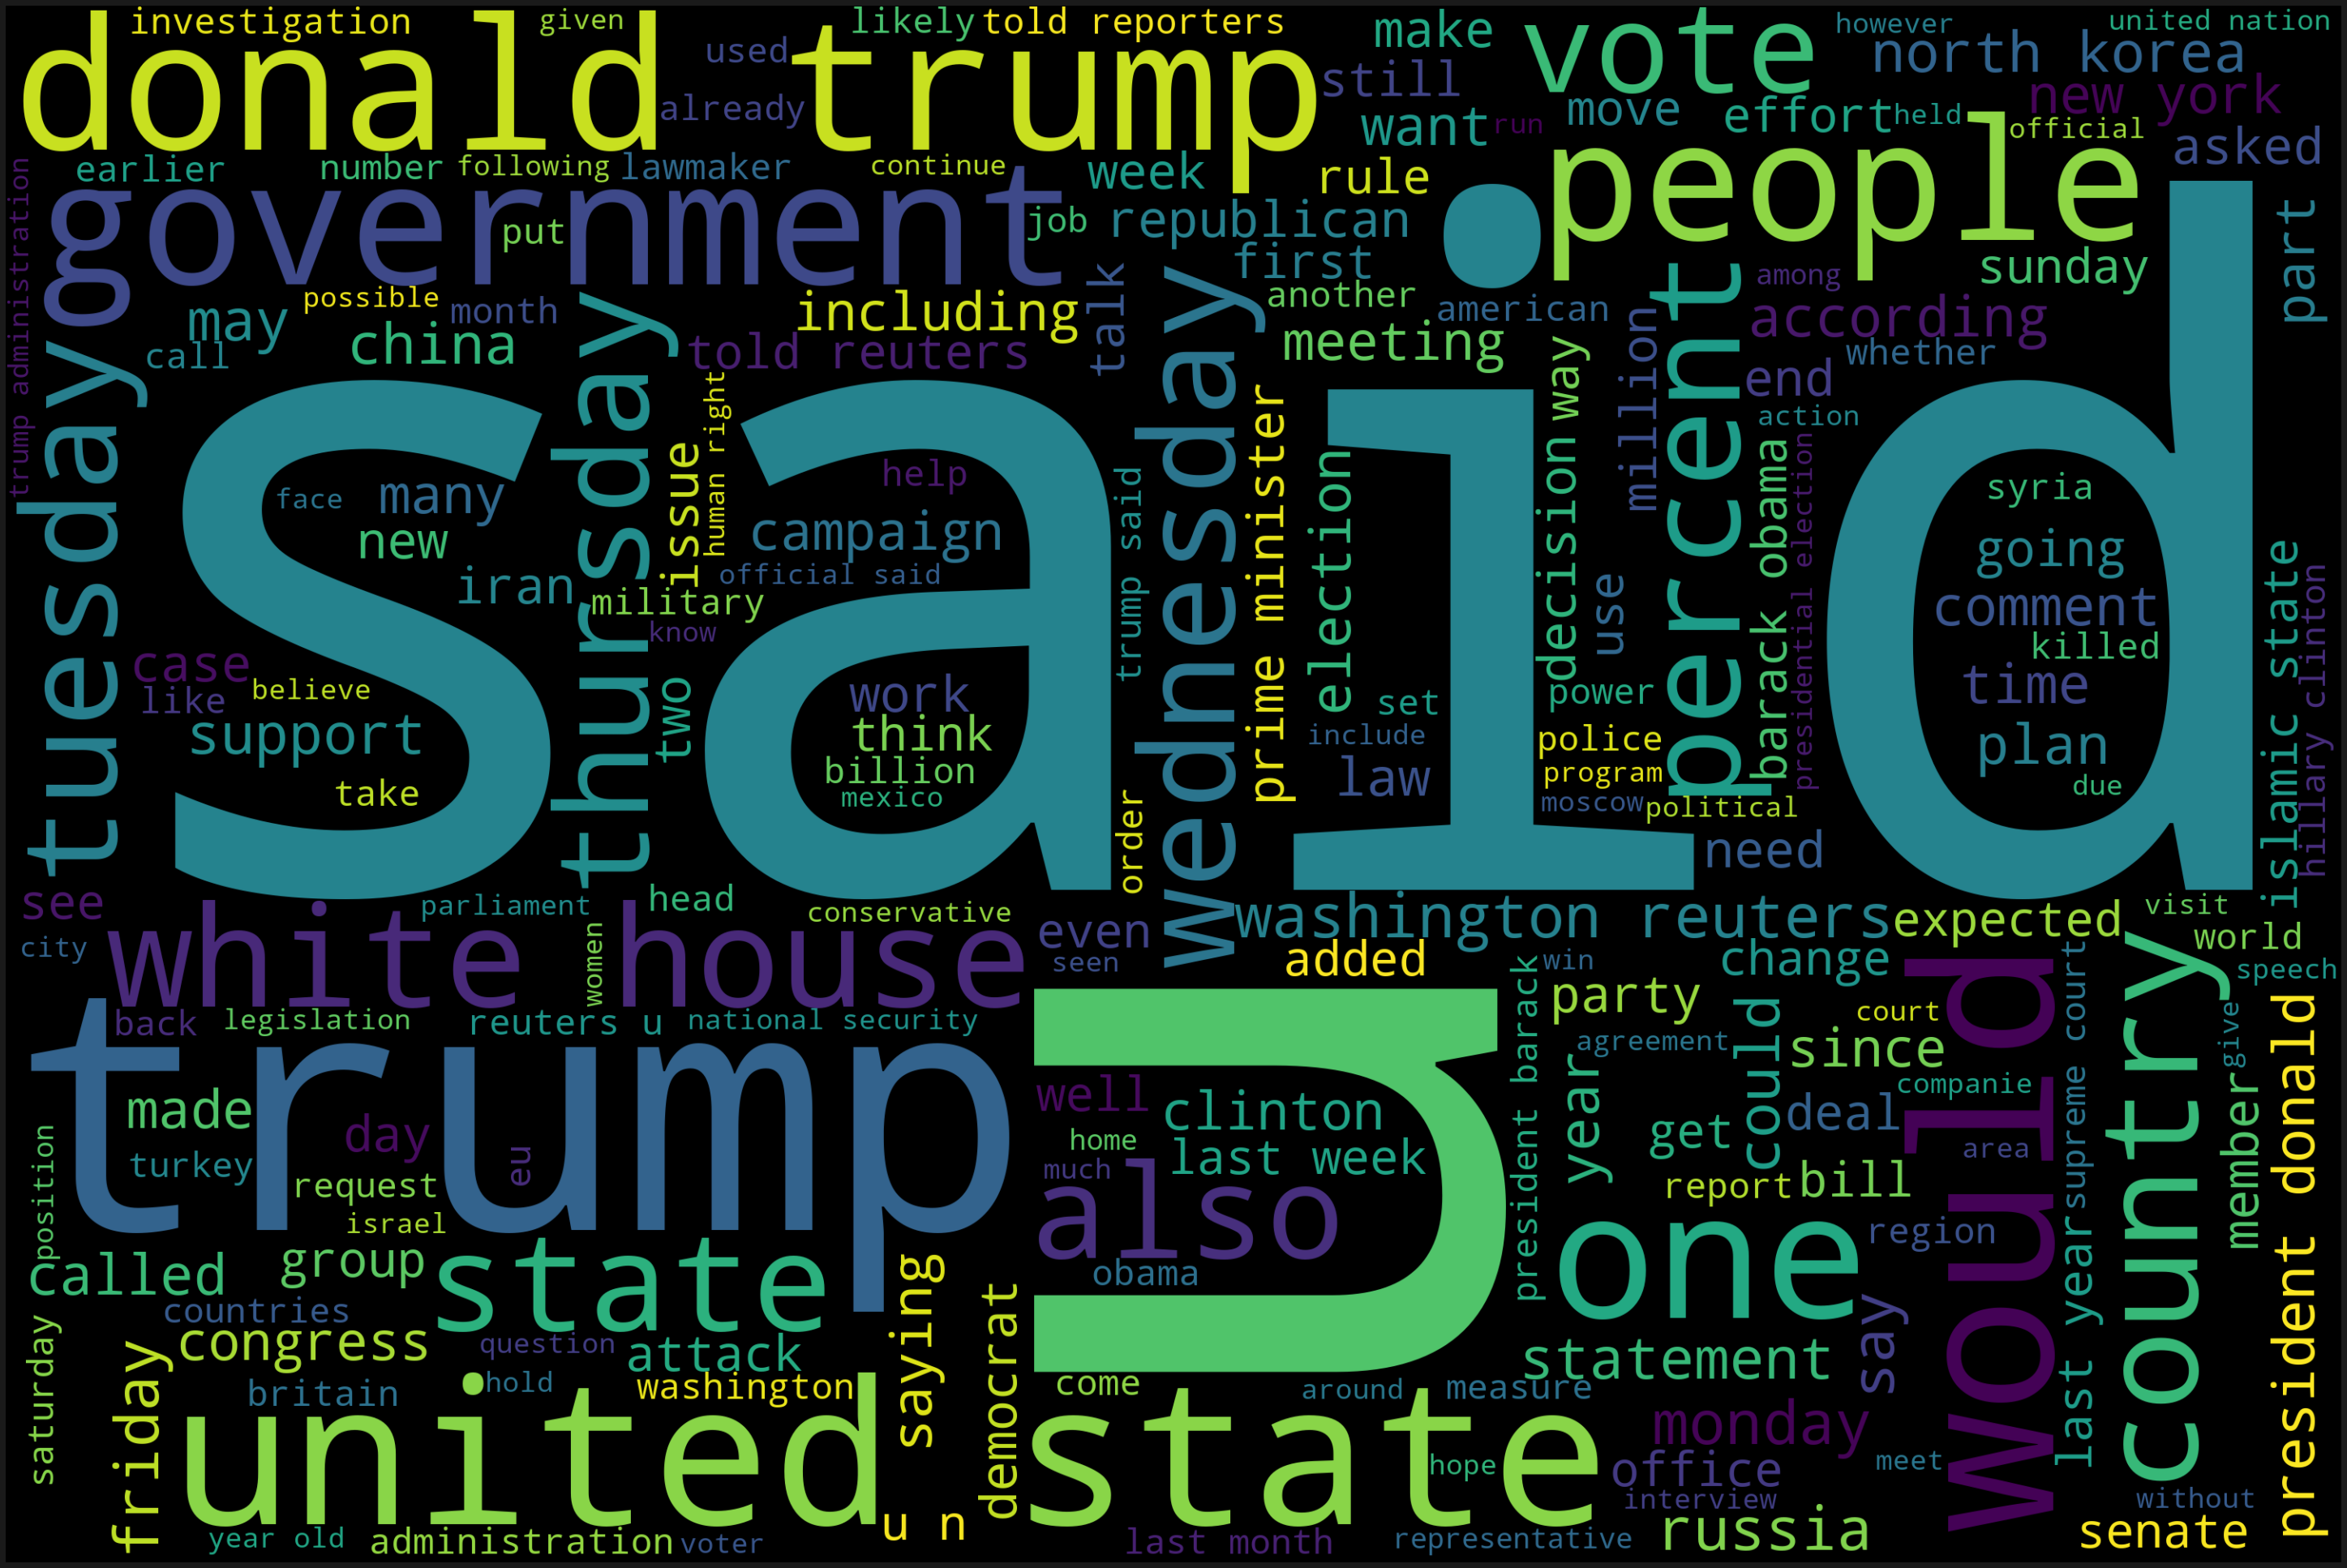

In [13]:
text = ''
for word in real_df_clean['text']:
    text += f" {word}"
    
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text.lower())

fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

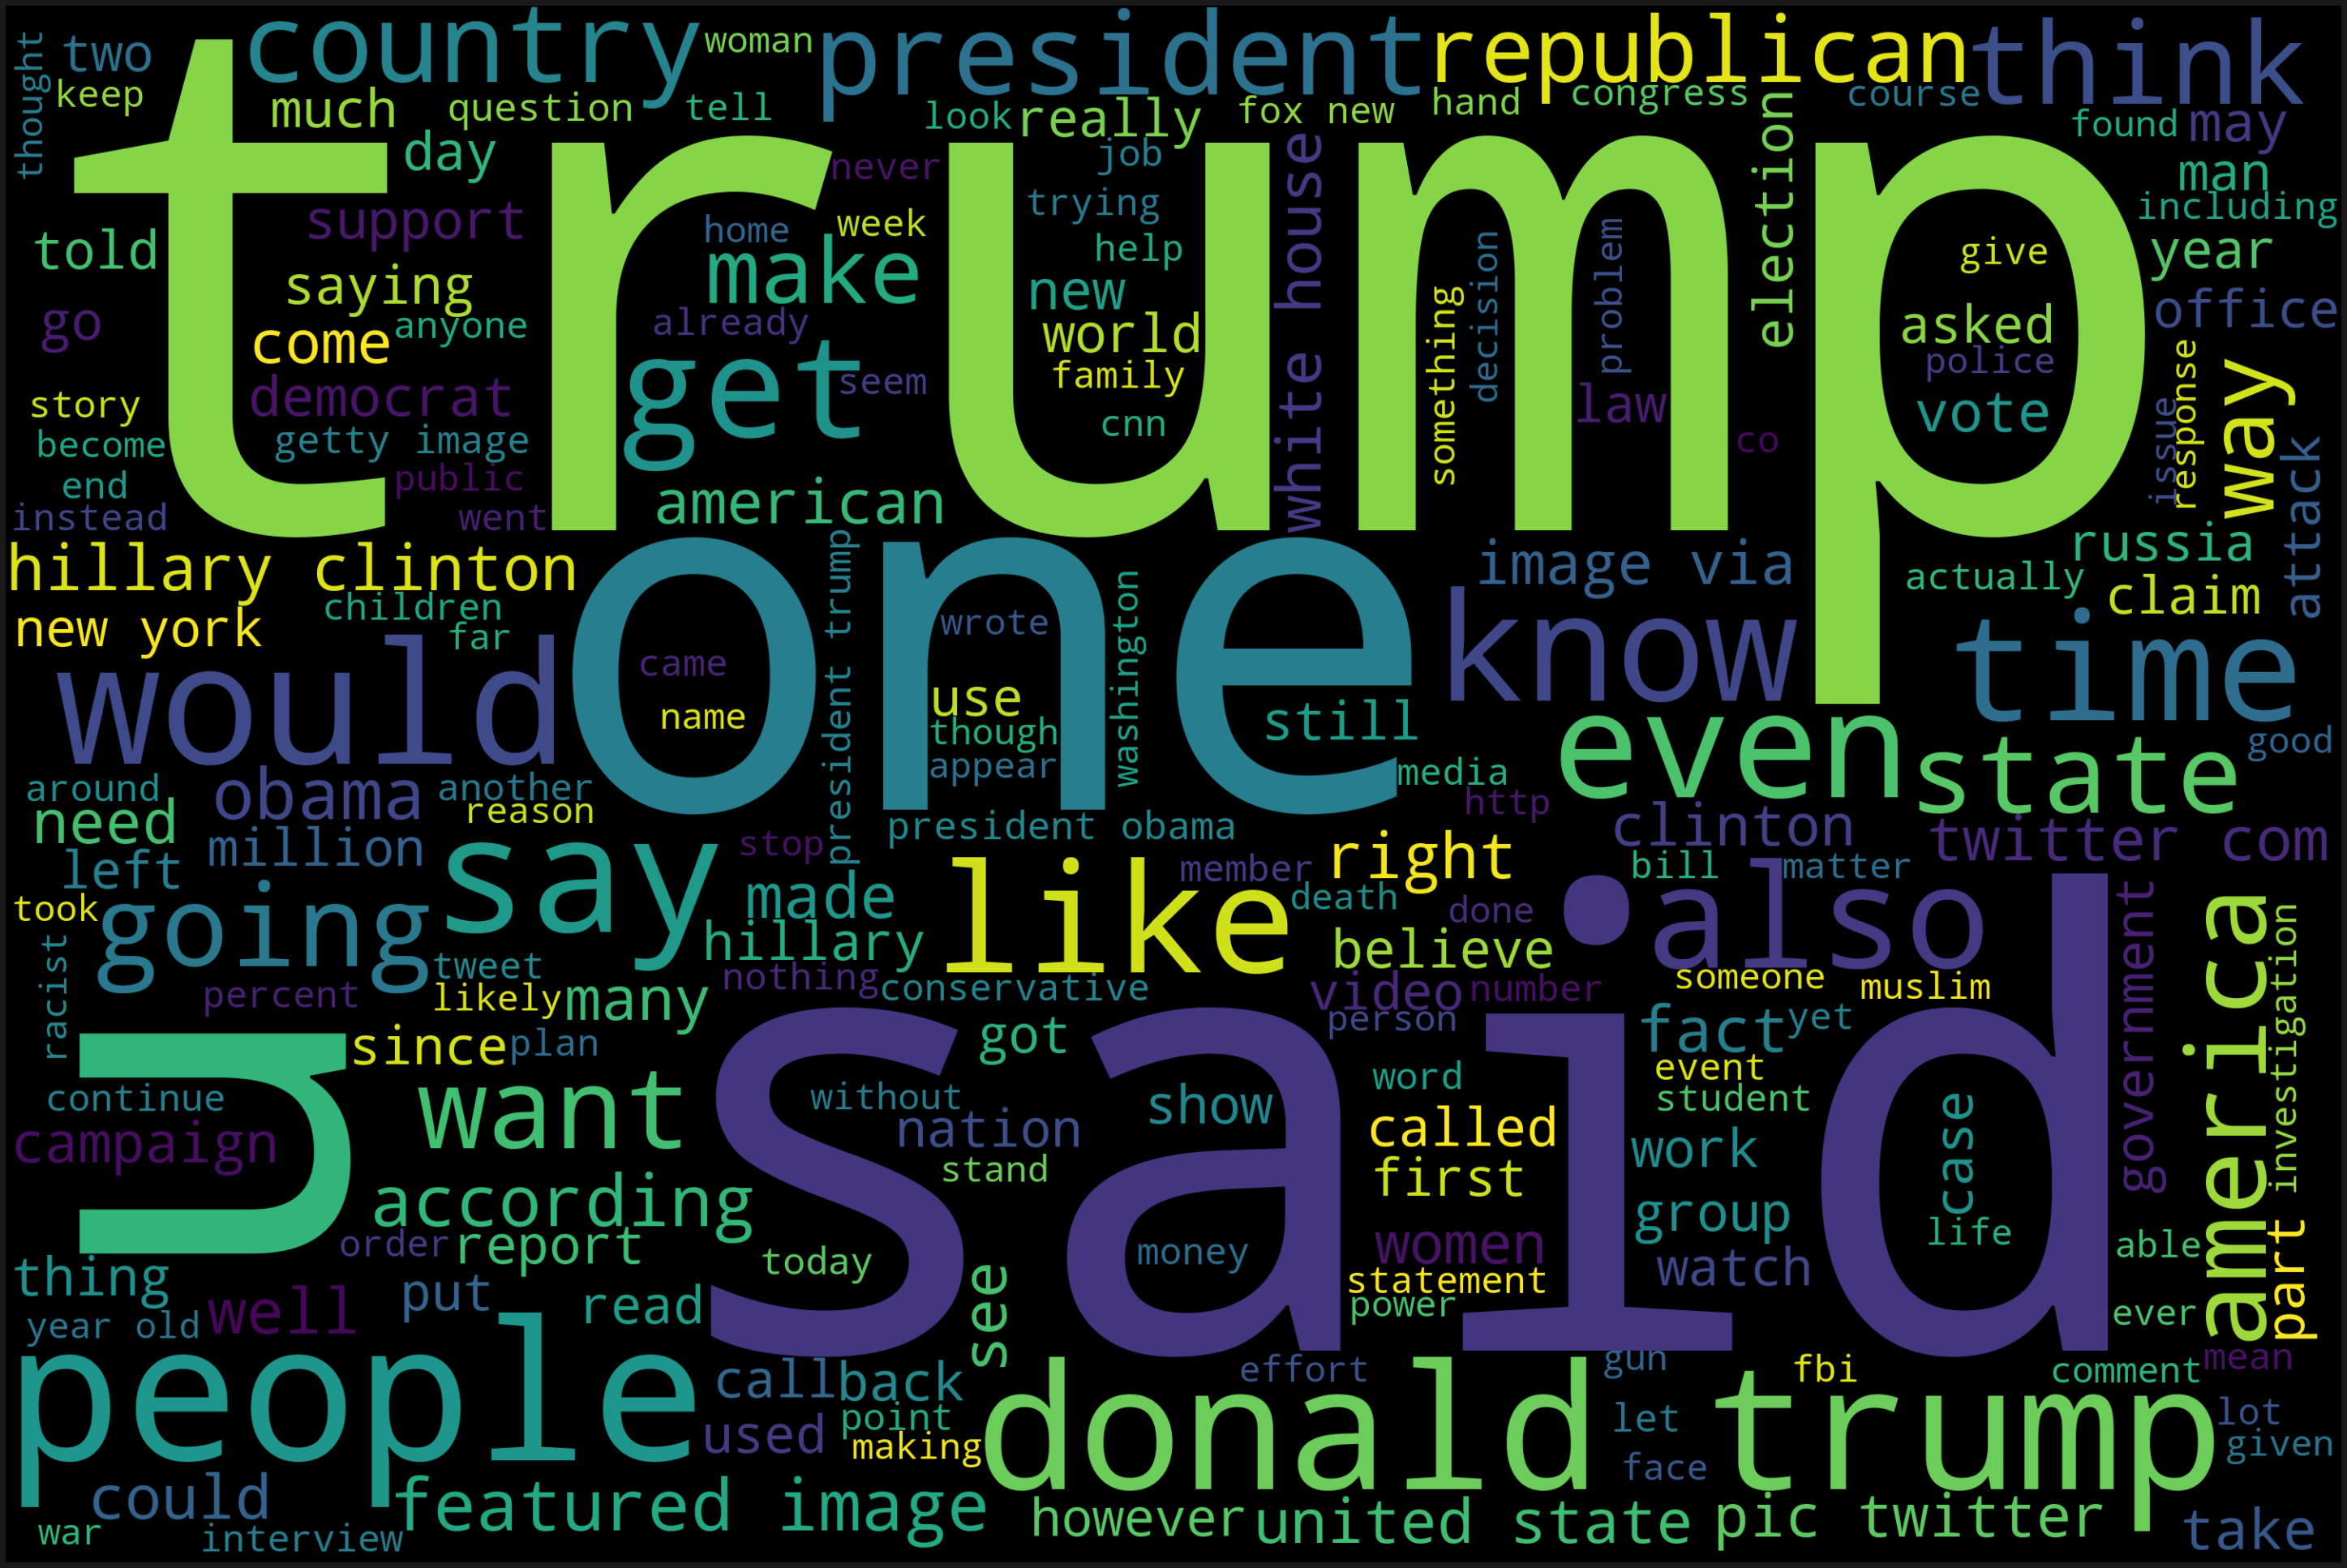

In [14]:
text = ''
for word in fake_df_clean['text']:
    text += f" {word}"
    
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text.lower())

fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Train Test Split

We need to split our data into groups to perform our analysis.

In [63]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
23476  21st Century Wire says As 21WIRE reported earl...   Middle-east   
23477  21st Century Wire says It s a familiar theme. ...   Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
23479  21st Century Wire says Al Jazeera America will...   Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  label  
0      December 31, 2017       1  
1      December 29, 2017       1  
2      December 31, 2017       1  
3      December 30, 2017       1  
4      December 29, 2017       1  
...                   ...    ...  
23476    January 16, 2016      0  
23477    January 16, 2016      0  
23478    January 15, 2016      0  
23479    January 14, 2016      0  
23480    January 12, 2016      0  

[44898 rows x 5 columns]

In [68]:
X = df[['text', 'label']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32)

In [70]:
# Convert to DataFrame
X_train = pd.DataFrame(X_train, columns=['text', 'label'])
X_test = pd.DataFrame(X_test, columns=['text', 'label'])
y_train = pd.DataFrame(y_train, columns=['label'])
y_test = pd.DataFrame(y_test, columns=['label'])

## Perform Data Cleaning

Before going any further, we'll complete two common data cleaning tasks for text data: standardizing case and tokenizing.

### Standardizing Case

In an NLP modeling process, sometimes we will want to preserve the original case of words (i.e. to treat `"It"` and `"it"` as different words, and sometimes we will want to standardize case (i.e. to treat `"It"` and `"it"` as the same word).

To figure out what we want to do, let's look at a sample from the data:

In [72]:
sample = X_train.iloc[6242]['text']
sample

"In case you have been living under a rock, we recently learned that Hillary Clinton is human through a series of reports about That One Time She Coughed and The Time She Got Pneumonia. Yes, somehow anytime Clinton gets the sniffles, the Right pounces on it, using anything and everything they can to push absolutely bonkers conspiracy theories about the former Secretary of State s health (she s on her deathbed, don tchaknow).During an interview with ACB s Sarina Fazan Wednesday, the reporter asked Clinton perhaps one of the dumbest f*cking questions she has been asked regarding her health: if she would undergo  neurocognitive tests  to appease inflated, only-existing-on-Trump s-side-of-the-aisle concerns about whether or not her presidency will be like a four-year-long edition of Weekend at Bernie s.Hillary just laughed in her face.  I m very sorry I got pneumonia, I m glad antibiotics took care of it, and that s behind us now,  the former Secretary of State said, somehow managing to av

Here we have multiple words that are capitalized. It seems reasonable to assume `"Coughed"` and `"coughed"` are the same word. So let's standardize the case of all letters in this dataset.

For a single sample, we can just use the built-in Python .lower() method:

In [73]:
sample = sample.lower()
sample

"in case you have been living under a rock, we recently learned that hillary clinton is human through a series of reports about that one time she coughed and the time she got pneumonia. yes, somehow anytime clinton gets the sniffles, the right pounces on it, using anything and everything they can to push absolutely bonkers conspiracy theories about the former secretary of state s health (she s on her deathbed, don tchaknow).during an interview with acb s sarina fazan wednesday, the reporter asked clinton perhaps one of the dumbest f*cking questions she has been asked regarding her health: if she would undergo  neurocognitive tests  to appease inflated, only-existing-on-trump s-side-of-the-aisle concerns about whether or not her presidency will be like a four-year-long edition of weekend at bernie s.hillary just laughed in her face.  i m very sorry i got pneumonia, i m glad antibiotics took care of it, and that s behind us now,  the former secretary of state said, somehow managing to av

Great, we can see that all of the text is now lowercase. Let's perform the same operation on the full `X_train`.

To access this method in pandas, we use `.str.lower()`:

In [74]:
# Transform sample data to lowercase
X_train['text'] = X_train['text'].str.lower()

# Display full text
X_train.head()

text  label
18091  jefferson county judge joseph j. bruzzese jr. ...      0
12277  jerusalem (reuters) - israel s supreme court r...      1
19215  vatican city (reuters) - the vatican s first a...      1
20617  geneva (reuters) - a european and african deal...      1
10863  just two months shy of the one-year anniversar...      0

Everything in the `text` column is now lowercase.

### Remove Miscellaneous Text

As we can see above, there are a lot of lines that contain `(reuters)` at the start of the text. Reuters is one of the largest news agencies in the world and just tells us who wrote the article. We should remove this from the start of the articles, but keep any references to `reuters` that is in the article.

In [75]:
reuters_example = X_train.iloc[19219]['text']

reuters_example

'abidjan (reuters) - german chancellor angela merkel on wednesday stressed the importance of ending smuggling and slavery while creating a legal route for africans to come to europe as she faces pressure at home to tackle a migrant influx. speaking at an eu-africa summit in abidjan, merkel is seeking to show germany can take foreign policy action despite still being under a caretaker government two months after an election. the influx of more than a million migrants since mid-2015, many of them fleeing the middle east and africa, was largely to blame for the rise of the anti-immigrant alternative for germany (afd) in the sept. 24 election. by taking votes from merkel s conservative bloc and others, they surged into parliament for the first time, leaving merkel facing complicated coalition arithmetic. she is grappling to form a new government with the centre-left social democrats (spd) after discussions on forming a three-way tie-up with the pro-business free democrats and the greens fa

It might be hard to see above, but the world `reuters` appears twice in this article: once at the start, and once about 3/4 the way down. We only want to remove the first `(reuters)` with the parathesis around it.

In [76]:
def remove_reuters(text):
    clean_lines = text.replace('(reuters)', '')
    return clean_lines

In [77]:
reuters_example = remove_reuters(reuters_example)
reuters_example

'abidjan  - german chancellor angela merkel on wednesday stressed the importance of ending smuggling and slavery while creating a legal route for africans to come to europe as she faces pressure at home to tackle a migrant influx. speaking at an eu-africa summit in abidjan, merkel is seeking to show germany can take foreign policy action despite still being under a caretaker government two months after an election. the influx of more than a million migrants since mid-2015, many of them fleeing the middle east and africa, was largely to blame for the rise of the anti-immigrant alternative for germany (afd) in the sept. 24 election. by taking votes from merkel s conservative bloc and others, they surged into parliament for the first time, leaving merkel facing complicated coalition arithmetic. she is grappling to form a new government with the centre-left social democrats (spd) after discussions on forming a three-way tie-up with the pro-business free democrats and the greens failed, in 

In [78]:
reuters_example[2049:2097]

'return,  he told reuters. the difference between'

Great! We can see here that the first `reuters` was removed, and the second one remains. Let's apply this to the whole `X_train`.

In [79]:
# Remove (reuters) from dataframe
X_train['text'] = X_train['text'].apply(remove_reuters)

# Display full text
X_train.head()

text  label
18091  jefferson county judge joseph j. bruzzese jr. ...      0
12277  jerusalem  - israel s supreme court ruled on t...      1
19215  vatican city  - the vatican s first auditor-ge...      1
20617  geneva  - a european and african deal to stem ...      1
10863  just two months shy of the one-year anniversar...      0

Perfect, it looked like the function removed `(reuters)` from the text.

### Remove Punctuation

Let's look more closely at the example from before:

In [80]:
sample

"in case you have been living under a rock, we recently learned that hillary clinton is human through a series of reports about that one time she coughed and the time she got pneumonia. yes, somehow anytime clinton gets the sniffles, the right pounces on it, using anything and everything they can to push absolutely bonkers conspiracy theories about the former secretary of state s health (she s on her deathbed, don tchaknow).during an interview with acb s sarina fazan wednesday, the reporter asked clinton perhaps one of the dumbest f*cking questions she has been asked regarding her health: if she would undergo  neurocognitive tests  to appease inflated, only-existing-on-trump s-side-of-the-aisle concerns about whether or not her presidency will be like a four-year-long edition of weekend at bernie s.hillary just laughed in her face.  i m very sorry i got pneumonia, i m glad antibiotics took care of it, and that s behind us now,  the former secretary of state said, somehow managing to av

If we split this into tokens just by using the built-in Python `.split` string method, we would have a lot of punctuation attached. Punctuation being attached to words is a problem because we probably want to treat `week` and `week.` as two instances of the same token, not two different tokens.

In [81]:
sample_no_punct = sample.translate(str.maketrans('', '', string.punctuation))

sample_no_punct

'in case you have been living under a rock we recently learned that hillary clinton is human through a series of reports about that one time she coughed and the time she got pneumonia yes somehow anytime clinton gets the sniffles the right pounces on it using anything and everything they can to push absolutely bonkers conspiracy theories about the former secretary of state s health she s on her deathbed don tchaknowduring an interview with acb s sarina fazan wednesday the reporter asked clinton perhaps one of the dumbest fcking questions she has been asked regarding her health if she would undergo  neurocognitive tests  to appease inflated onlyexistingontrump ssideoftheaisle concerns about whether or not her presidency will be like a fouryearlong edition of weekend at bernie shillary just laughed in her face  i m very sorry i got pneumonia i m glad antibiotics took care of it and that s behind us now  the former secretary of state said somehow managing to avoid knocking the reporter fo

Let's apply this to the full `X_train`.

In [82]:
# Remove punctuation from dataframe
X_train['text'] = X_train['text'].str.translate(str.maketrans('', '', string.punctuation))

In [83]:
# Remove random punctuation from dataframe
X_train['text'] = X_train['text'].str.translate(str.maketrans('', '', '’'))
X_train['text'] = X_train['text'].str.translate(str.maketrans('', '', '“'))
X_train['text'] = X_train['text'].str.translate(str.maketrans('', '', '”'))

# Display full text
X_train.head()

text  label
18091  jefferson county judge joseph j bruzzese jr sh...      0
12277  jerusalem   israel s supreme court ruled on th...      1
19215  vatican city   the vatican s first auditorgene...      1
20617  geneva   a european and african deal to stem t...      1
10863  just two months shy of the oneyear anniversary...      0

We can see that all of the punctuation has been removed from the dataset.

### Remove Single Letter Words

We can see above our `text` column contains single letter words such as `a`, `s`, etc. Since these don't do us any good, let's remove those from our series.

In [84]:
X_train['text'] = X_train['text'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')

X_train.head()

text  label
18091  jefferson county judge joseph bruzzese jr shou...      0
12277  jerusalem israel supreme court ruled on thursd...      1
19215  vatican city the vatican first auditorgeneral ...      1
20617  geneva european and african deal to stem the f...      1
10863  just two months shy of the oneyear anniversary...      0

### Tokenizing the Full Dataset

Now that the case is consistent, punctuation has been removed, and no single letter words remain, it's time to convert each document from a single long string into a set of tokens.

The best way to do this is to use `nltk`'s tool `word_tokenize`.

In [85]:
sample = X_train.iloc[3451]['text']

sample

'you might remember few months ago the bernie sanders campaign filed lawsuit against the democratic national committee for cutting off access to their own campaign data stored on the servers at dnc headquarters the cut off came from when few sanders staffers found they could access protected private information of the hillary clinton campaign which was stored on the same serversthe dnc came out quickly and said that the sanders staffers intentionally exploited software errors to gain access to the clinton team proprietary data sanders fired back immediately that the error has been recurring one and his campaign had attempted to make it known to the dnc that this was happening before with no success in getting it resolveddnc chairwoman debbie wasserman schultz said that the extreme move in cutting off access to the sanders campaign of even their own data was the only way to protect the other data on the servers wasserman schultz also said that the sanders campaign not only viewed it but

In [86]:
sample_tokens = word_tokenize(sample)

sample_tokens

['you',
 'might',
 'remember',
 'few',
 'months',
 'ago',
 'the',
 'bernie',
 'sanders',
 'campaign',
 'filed',
 'lawsuit',
 'against',
 'the',
 'democratic',
 'national',
 'committee',
 'for',
 'cutting',
 'off',
 'access',
 'to',
 'their',
 'own',
 'campaign',
 'data',
 'stored',
 'on',
 'the',
 'servers',
 'at',
 'dnc',
 'headquarters',
 'the',
 'cut',
 'off',
 'came',
 'from',
 'when',
 'few',
 'sanders',
 'staffers',
 'found',
 'they',
 'could',
 'access',
 'protected',
 'private',
 'information',
 'of',
 'the',
 'hillary',
 'clinton',
 'campaign',
 'which',
 'was',
 'stored',
 'on',
 'the',
 'same',
 'serversthe',
 'dnc',
 'came',
 'out',
 'quickly',
 'and',
 'said',
 'that',
 'the',
 'sanders',
 'staffers',
 'intentionally',
 'exploited',
 'software',
 'errors',
 'to',
 'gain',
 'access',
 'to',
 'the',
 'clinton',
 'team',
 'proprietary',
 'data',
 'sanders',
 'fired',
 'back',
 'immediately',
 'that',
 'the',
 'error',
 'has',
 'been',
 'recurring',
 'one',
 'and',
 'his',
 'c

In [87]:
# Create new column with tokenized data
X_train["text_tokenized"] = X_train["text"].apply(word_tokenize)

# Display full text
X_train

text  label  \
18091  jefferson county judge joseph bruzzese jr shou...      0   
12277  jerusalem israel supreme court ruled on thursd...      1   
19215  vatican city the vatican first auditorgeneral ...      1   
20617  geneva european and african deal to stem the f...      1   
10863  just two months shy of the oneyear anniversary...      0   
...                                                  ...    ...   
3411   conservatives are lying when they claim bannin...      0   
20414  moscow russian president vladimir putin and ge...      1   
9526   new yorkwellington erik duhaime is passive sto...      1   
21122  are you tired of supporting companies who are ...      0   
10967  washington republican us senator rob portman o...      1   

                                          text_tokenized  
18091  [jefferson, county, judge, joseph, bruzzese, j...  
12277  [jerusalem, israel, supreme, court, ruled, on,...  
19215  [vatican, city, the, vatican, first, auditorge...  
20617  [geneva, european, and, african, deal, to, ste...  
10863  [just, two, months, shy, of, the, oneyear, ann...  
...                                                  ...  
3411   [conservatives, are, lying, when, they, claim,...  
20414  [moscow, russian, president, vladimir, putin, ...  
9526   [new, yorkwellington, erik, duhaime, is, passi...  
21122  [are, you, tired, of, supporting, companies, w...  
10967  [washington, republican, us, senator, rob, por...  

[33673 rows x 3 columns]

### Frequency Distributions

Now we'll use another handy tool from NLTK called `FreqDist` ([documentation here](https://www.nltk.org/api/nltk.html?highlight=freqdist#nltk.probability.FreqDist)). `FreqDist` allows us to pass in a single list of words, and it produces a dictionary-like output of those words and their frequencies.

For example, this creates a frequency distribution of the sample we have been working with.

In [88]:
sample_freq_dist = FreqDist(sample_tokens)
sample_freq_dist

FreqDist({'the': 43, 'to': 19, 'and': 13, 'dnc': 12, 'campaign': 11, 'that': 11, 'of': 10, 'sanders': 8, 'was': 7, 'it': 7, ...})

We can use Matplotlib to visualize the most common words:

In [89]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

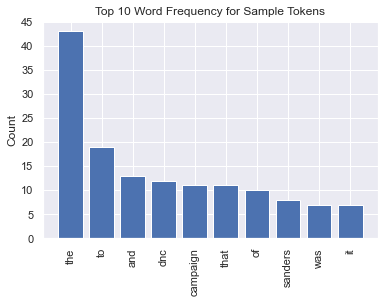

In [90]:
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency for Sample Tokens")

Interpreting the chart above is a bit artificial, since this sample only included 1 article. But essentially this is saying that the tokens with the highest frequency in our example are "the", "to", and "and".

### Visualizing the Frequency Distribution for the Full Dataset

Let's do that for the full dataset.

First, we need a list of all of the words in the text_tokenized column. We could do this manually by looping over the rows, but fortunately pandas has a handy method called `.explode()` ([documentation here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.explode.html#pandas.Series.explode)) that does exactly this.

Here is an example applying that to the full `X_train`:

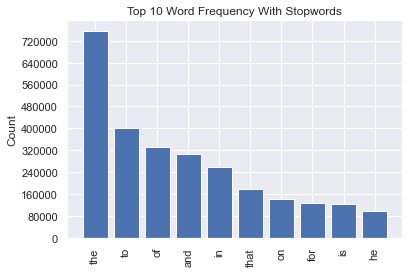

In [91]:
# Create a frequency distribution for full dataframe
text_with_stopwords = FreqDist(X_train['text_tokenized'].explode())

# Plot the top 10 tokens
visualize_top_10(text_with_stopwords, "Top 10 Word Frequency With Stopwords")

We can see that this didn't do us much good as most of these words do not contain real info. Let's re-run this code with the stopwords not included.

### Remove Stopwords

In general we assume that stopwords do not contain useful information, but that is not always the case. In our case, let's remove these stopwords and see what our frequency distribution looks like compared to above.


####  Stopwords List

Once again, NLTK has a useful tool for this task. We can just import a list of standard stopwords:

In [92]:
nltk.download('stopwords', quiet=True)

stopwords_list = stopwords.words('english')
stopwords_list[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [93]:
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

Let's test this function out on our sample.

In [94]:
print("Length with stopwords:", len(sample_freq_dist))

tokens_example_without_stopwords = remove_stopwords(sample_freq_dist)

print("Length without stopwords:", len(tokens_example_without_stopwords))

Length with stopwords: 252
Length without stopwords: 189


Great, that worked. Now we can apply it to our entire dataframe.

In [95]:
X_train["text_without_stopwords"] = X_train["text_tokenized"].apply(remove_stopwords)

X_train

text  label  \
18091  jefferson county judge joseph bruzzese jr shou...      0   
12277  jerusalem israel supreme court ruled on thursd...      1   
19215  vatican city the vatican first auditorgeneral ...      1   
20617  geneva european and african deal to stem the f...      1   
10863  just two months shy of the oneyear anniversary...      0   
...                                                  ...    ...   
3411   conservatives are lying when they claim bannin...      0   
20414  moscow russian president vladimir putin and ge...      1   
9526   new yorkwellington erik duhaime is passive sto...      1   
21122  are you tired of supporting companies who are ...      0   
10967  washington republican us senator rob portman o...      1   

                                          text_tokenized  \
18091  [jefferson, county, judge, joseph, bruzzese, j...   
12277  [jerusalem, israel, supreme, court, ruled, on,...   
19215  [vatican, city, the, vatican, first, auditorge...   
20617  [geneva, european, and, african, deal, to, ste...   
10863  [just, two, months, shy, of, the, oneyear, ann...   
...                                                  ...   
3411   [conservatives, are, lying, when, they, claim,...   
20414  [moscow, russian, president, vladimir, putin, ...   
9526   [new, yorkwellington, erik, duhaime, is, passi...   
21122  [are, you, tired, of, supporting, companies, w...   
10967  [washington, republican, us, senator, rob, por...   

                                  text_without_stopwords  
18091  [jefferson, county, judge, joseph, bruzzese, j...  
12277  [jerusalem, israel, supreme, court, ruled, thu...  
19215  [vatican, city, vatican, first, auditorgeneral...  
20617  [geneva, european, african, deal, stem, flow, ...  
10863  [two, months, shy, oneyear, anniversary, rich,...  
...                                                  ...  
3411   [conservatives, lying, claim, banning, abortio...  
20414  [moscow, russian, president, vladimir, putin, ...  
9526   [new, yorkwellington, erik, duhaime, passive, ...  
21122  [tired, supporting, companies, care, less, fut...  
10967  [washington, republican, us, senator, rob, por...  

[33673 rows x 4 columns]

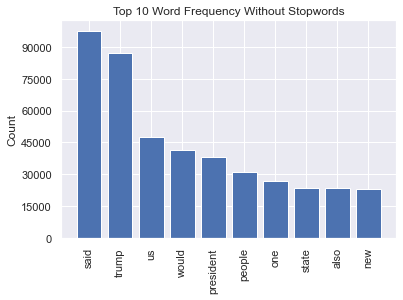

In [96]:
# Create a frequency distribution for full dataframe
text_without_stopwords = FreqDist(X_train['text_without_stopwords'].explode())

# Plot the top 10 tokens
visualize_top_10(text_without_stopwords, "Top 10 Word Frequency Without Stopwords")

Ok great, we have a general sense of the word frequencies in our dataset! 

In [97]:
text_without_stopwords

FreqDist({'said': 97633, 'trump': 87235, 'us': 47519, 'would': 41400, 'president': 38305, 'people': 30921, 'one': 26662, 'state': 23439, 'also': 23364, 'new': 23149, ...})

## Build and Evaluate a Baseline Model

Let's start modeling by building a model that basically only has access to the information in the plots above. So, using the default token pattern to split the full text into tokens, and using a limited vocabulary.

To give the model a little bit more information with those same features, we'll use a `TfidfVectorizer` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) so that it counts not only the term frequency (`tf`) within a single document, it also includes the inverse document frequency (`idf`) — how rare the term is.

In the cell below we instantiate a vectorizer object and fit it on `X_train["text"]`.

In [99]:
# Instantiate a vectorizer with max_features=10
tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

and       for        he        in        is        of        on  \
0      0.182108  0.120310  0.578082  0.109366  0.287226  0.072101  0.074000   
1      0.227569  0.167049  0.000000  0.341668  0.042730  0.337876  0.115592   
2      0.171059  0.086931  0.417699  0.184387  0.014824  0.403754  0.120307   
3      0.387440  0.056881  0.170818  0.206826  0.087298  0.255662  0.209918   
4      0.302887  0.095287  0.208113  0.267731  0.048747  0.311482  0.155847   
...         ...       ...       ...       ...       ...       ...       ...   
33668  0.354556  0.000000  0.000000  0.070977  0.199720  0.456227  0.036019   
33669  0.346891  0.000000  0.000000  0.069442  0.078161  0.343357  0.211441   
33670  0.181071  0.214712  0.165805  0.334594  0.156918  0.386027  0.212247   
33671  0.270532  0.099293  0.000000  0.270782  0.406373  0.565305  0.091610   
33672  0.099170  0.054598  0.131169  0.397047  0.167587  0.441720  0.100746   

           that       the        to  
0      0.235025  0.628741  0.249993  
1      0.081582  0.727499  0.371905  
2      0.183971  0.656215  0.335464  
3      0.111116  0.693606  0.405233  
4      0.194604  0.735640  0.285425  
...         ...       ...       ...  
33668  0.266924  0.612066  0.417193  
33669  0.223846  0.798446  0.136058  
33670  0.074900  0.641192  0.382415  
33671  0.129312  0.432423  0.383169  
33672  0.213312  0.618210  0.388967  

[33673 rows x 10 columns]

Now that we have preprocessed data, fit and evaluate a multinomial Naive Bayes classifier ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)) using cross_val_score ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)).

In [100]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

array([0.67646622, 0.67542687, 0.68389013, 0.67701218, 0.68072468])

How well is this model performing? Well, recall the class balance:

In [102]:
X_train['label'].value_counts(normalize=True)

0    0.523387
1    0.476613
Name: label, dtype: float64

If we guessed the majority class every time (class 0, or Fake News), we would expect about 52.2% accuracy. So when this model is getting 67-68% accuracy, that is a clear improvement over just guessing. Let's see if we can improve that with more sophisticated preprocessing.

## Iteratively Perform and Evaluate Preprocessing and Feature Engineering Techniques

Now that we have our baseline, the fun part begins. As we've seen, preprocessing text data is a bit more challenging that working with more traditional data types because there's no clear-cut answer for exactly what sort of preprocessing we need to do. As we are preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words or not?
* What should be counted as a token? Do we stem or lemmatize our text data, or leave the words as is? Do we want to include non-"words" in our tokens?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

### Removing Stopwords

Let's begin with the first question: *do we remove stopwords or not?* In general we assume that stopwords do not contain useful information, but that is not always the case. Let's empirically investigate the top word frequencies of each category to see whether removing stopwords helps us to distinguish between the categories.

As-is, recall that the raw word frequency distributions of the categories look very similar. They both include `said` and `trump` but in different orders.

If we remove stopwords, how does this change the frequency distributions for each category?

In [104]:
# Separate Real News from Fake News
real_news = X_train[X_train['label'] == 1]
fake_news = X_train[X_train['label'] == 0]

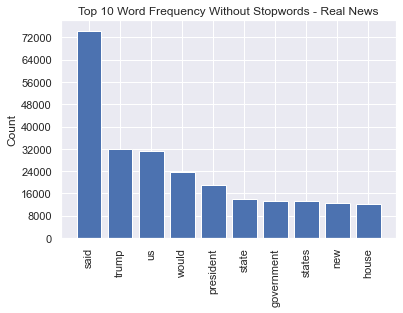

In [106]:
# Create a frequency distribution for full dataframe
text_without_stopwords = FreqDist(real_news['text_without_stopwords'].explode())

# Plot the top 10 tokens
visualize_top_10(text_without_stopwords, "Top 10 Word Frequency Without Stopwords - Real News")

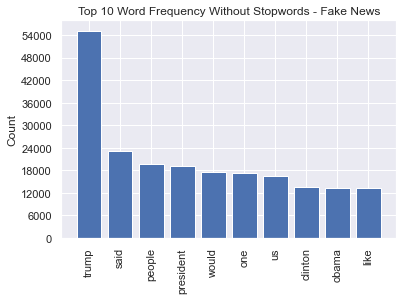

In [107]:
# Create a frequency distribution for full dataframe
text_without_stopwords = FreqDist(fake_news['text_without_stopwords'].explode())

# Plot the top 10 tokens
visualize_top_10(text_without_stopwords, "Top 10 Word Frequency Without Stopwords - Fake News")

The most common words differ slightly between categories, meaning that hopefully our model will have an easier time distinguishing between them.

Let's redo our modeling process, using stopwords_list when instantiating the vectorizer:

In [108]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_features=10, stop_words=stopwords_list)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

also       new       one    people  president      said     state  \
0      0.694826  0.000000  0.338100  0.000000   0.000000  0.488542  0.405254   
1      0.000000  0.000000  0.000000  0.000000   0.000000  0.516233  0.856448   
2      0.197751  0.000000  0.000000  0.064910   0.000000  0.973292  0.076892   
3      0.212784  0.000000  0.000000  0.628598   0.000000  0.748056  0.000000   
4      0.175538  0.335292  0.512496  0.345712   0.117794  0.586260  0.051191   
...         ...       ...       ...       ...        ...       ...       ...   
33668  0.000000  0.538000  0.479696  0.000000   0.000000  0.693144  0.000000   
33669  0.000000  0.000000  0.000000  0.000000   0.536813  0.843701  0.000000   
33670  0.261833  0.571569  0.318517  0.193375   0.058567  0.414221  0.000000   
33671  0.000000  0.250277  0.446308  0.225798   0.000000  0.000000  0.802432   
33672  0.000000  0.355542  0.000000  0.000000   0.291452  0.687106  0.379978   

          trump        us     would  
0      0.000000  0.000000  0.000000  
1      0.000000  0.000000  0.000000  
2      0.000000  0.000000  0.058922  
3      0.000000  0.000000  0.000000  
4      0.040577  0.119459  0.313821  
...         ...       ...       ...  
33668  0.000000  0.000000  0.000000  
33669  0.000000  0.000000  0.000000  
33670  0.484202  0.237580  0.000000  
33671  0.000000  0.208061  0.000000  
33672  0.000000  0.295572  0.291178  

[33673 rows x 10 columns]

In [109]:
# Evaluate the classifier on X_train_vectorized and y_train
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stopwords_removed_cv

C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

array([0.7783222 , 0.77342242, 0.76985895, 0.77368577, 0.76730027])

In [110]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.6787040159423233
Stopwords removed: 0.7725179208920857


Looks like we have a about 10% improvement. So, to answer *do we remove stopwords or not:* **yes, let's remove stopwords.**

### Using Custom Tokens

Our next question is what should be counted as a token?

Recall that currently we are using the default token pattern, which finds words of two or more characters. What happens if we also stem those words, so that `swims` and `swimming` would count as the same token?

Below is a custom tokenizing function:

In [112]:
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [114]:
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

In [123]:
print("Original sample:", X_train.iloc[100]["text_tokenized"][45:55])
print("Stemmed sample: ", stem_and_tokenize(X_train.iloc[100]["text"])[45:55])

Original sample: ['global', 'powers', 'this', 'week', 'and', 'add', 'its', 'revolutionary', 'guards', 'military']
Stemmed sample:  ['global', 'power', 'this', 'week', 'and', 'add', 'it', 'revolutionari', 'guard', 'militari']


We also need to stem our stopwords:

In [124]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In the cells below, we will repeat the modeling process from earlier. 

* max_features=10 (same as previous)
* stop_words=stemmed_stopwords (modified)
* tokenizer=stem_and_tokenize (new)

In [125]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_features=10, stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

one     peopl    presid  republican      said       say     state  \
0      0.444300  0.000000  0.000000    0.000000  0.649242  0.446092  0.426714   
1      0.000000  0.000000  0.000000    0.000000  0.605459  0.000000  0.795876   
2      0.000000  0.065495  0.000000    0.000000  0.985748  0.129010  0.061703   
3      0.000000  0.629258  0.000000    0.000000  0.751655  0.000000  0.197610   
4      0.549580  0.373507  0.125307    0.000000  0.635776  0.045983  0.043986   
...         ...       ...       ...         ...       ...       ...       ...   
33668  0.496431  0.000000  0.000000    0.000000  0.725420  0.000000  0.476782   
33669  0.000000  0.000000  0.529466    0.000000  0.848331  0.000000  0.000000   
33670  0.343185  0.209913  0.062598    0.168444  0.451337  0.068914  0.131841   
33671  0.530186  0.270245  0.000000    0.000000  0.000000  0.000000  0.763802   
33672  0.000000  0.000000  0.168658    0.680760  0.405346  0.000000  0.532827   

          trump        us     would  
0      0.000000  0.000000  0.000000  
1      0.000000  0.000000  0.000000  
2      0.000000  0.000000  0.059676  
3      0.000000  0.000000  0.000000  
4      0.043448  0.129548  0.340326  
...         ...       ...       ...  
33668  0.000000  0.000000  0.000000  
33669  0.000000  0.000000  0.000000  
33670  0.716254  0.258868  0.000000  
33671  0.000000  0.249953  0.000000  
33672  0.000000  0.174367  0.171775  

[33673 rows x 10 columns]

In [126]:
# Evaluate the classifier on X_train_vectorized and y_train
stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stemmed_cv

C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\kevgr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

array([0.77238307, 0.76807721, 0.76109874, 0.76685477, 0.75868726])

In [127]:
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Stopwords removed: 0.7725179208920857
Stemmed:           0.7654202091173138


Interesting! Our model actually did not improve when we stemmed our tokens. So, our best modeling process for now is one where we remove stopwords and use the default token pattern, but not stem our tokens with a snowball stemmer.

### Domain-Specific Feature Engineering

The way to really get the most information out of text data is by adding features beyond just vectorizing the tokens.

**Number of Sentences**

Does the number of sentences in a post differ by category? Let's investigate.

Once again, there is a tool from NLTK that helps with this task.